# EGM722 - Week 5 Practical: Vector and raster operations using python

## Overview

Up to now, we have worked with either vector data or raster data, but we haven't really used them together. In this week's practical, we'll learn how we can combine these two data types, and see some examples of different analyses, such as zonal statistics or sampling raster data, that we can automate using python.

## Objectives
-  learn how to use `rasterstats` to perform zonal statistics
-  use the `zip` built-in to combine iterables such as lists
-  learn how to handle exceptions using `try` ... `except` blocks
-  rasterize polygon data using `rasterio`
-  learn how to mask and select (index) rasters using vector data
-  see additional plotting examples using `matplotlib`

## Data provided

In the data\_files folder, you should have the following:
-  LCM2015_Aggregate_100m.tif
-  NI_DEM.tif


## 1. Getting started

In this practical, we'll look at a number of different GIS tasks related to working with both raster and vector data in python, as well as a few different python and programming concepts. To get started, run the cell below.

In [9]:
%matplotlib notebook

import numpy as np
import rasterio as rio
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterstats

plt.rcParams.update({'font.size': 22}) # update the font size for our plots to be size 22

## 2. Zonal statistics
In GIS, [_zonal statistics_](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-analyst/how-zonal-statistics-works.htm) is a process whereby you calculate statistics for the pixels of a raster in different groups, or zones, defined by properties in another dataset. In this example, we're going to use the Northern Ireland County border dataset from Week 2, along with a re-classified version of the Northern Ireland [Land Cover Map](https://catalogue.ceh.ac.uk/documents/47f053a0-e34f-4534-a843-76f0a0998a2f) 2015[<sup id="fn1-back">1</sup>](#fn1 "footnote 1").

The Land Cover Map tells, for each pixel, what type of land cover is associated with a location - that is, whether it's woodland (and what kind of woodland), grassland, urban or built-up areas, and so on. For our re-classified version of the dataset, we're working with the aggregate class data, re-sampled to 100m resolution from the original 25m resolution.

The raster data type is _unsigned integer_ with a _bitdepth_ of 8 bits - that is, it has a range of possible values from 0 to 255. Even though it has this range of possible values, we only use 10 (11) of them:

| Raster value | Aggregate class name       |
| :------------|:---------------------------|
| 0            | No Data                    |
| 1            | Broadleaf woodland         |
| 2            | Coniferous woodland        |
| 3            | Arable                     |
| 4            | Improved grassland         |
| 5            | Semi-natural grassland     |
| 6            | Mountain, heath, bog       |
| 7            | Saltwater                  |
| 8            | Freshwater                 |
| 9            | Coastal                    |
| 10           | Built-up areas and gardens |

In the cell below, we'll create a __dict__ object of __key__/__value__ pairs that maps each raster value (the __key__) to a class name (the __value__):

In [10]:
landcover_names = {1: 'Broadleaf woodland',
                   2: 'Coniferous woodland',
                   3: 'Arable',
                   4: 'Improved grassland',
                   5: 'Semi-natural grassland',
                   6: 'Mountain, heath, bog',
                   7: 'Saltwater',
                   8: 'Freshwater',
                   9: 'Coastal',
                   10: 'Built-up areas and gardens'}

We'll use this later on, when we want to make our outputs more readable/understandable.

In this part of the practical, we'll try to work out the percentage of the entire country, and of each county individually, that is covered by each of these different landcovers. 

To start, we'll load the `LCM2015_Aggregate_100m.tif` raster, as well as the counties shapefile from Week 2:

In [11]:
# open the land cover raster and read the data
with rio.open('data_files/LCM2015_Aggregate_100m.tif') as dataset:
    xmin, ymin, xmax, ymax = dataset.bounds 
    crs = dataset.crs
    landcover = dataset.read(1)
    affine_tfm = dataset.transform

# now, load the county dataset from the week 2 folder
counties = gpd.read_file('../Week2/data_files/Counties.shp').to_crs(crs)

Next, we'll define a function that takes an array, and returns a __dict__ object containing the count (number of pixels) for each of the unique values in the array:

```python
def count_unique(array, names, nodata=0):
    '''
    Count the unique elements of an array.

    :param array: Input array
    :param names: a dict of key/value pairs that map raster values to a name
    :param nodata: nodata value to ignore in the counting
    
    :returns count_dict: a dictionary of unique values and counts
    '''
    count_dict = dict() # create the output dict
    for val in np.unique(array): # iterate over the unique values for the raster
        if val == nodata: # if the value is equal to our nodata value, move on to the next one
            continue
        count_dict[names[val]] = np.count_nonzero(array == val)
    return count_dict # return the now-populated output dict
```

Here, we have three input parameters: the first, `array`, is our array (or raster data). The next, `names`, is a dict of __key__/__value__ pairs to provide human-readable names for each raster value. Finally, `nodata` is the value of the array that we should ignore. 

The first line of the function defines an empty __dict__ (`count_dict = dict()`), into which we'll place the __key__/__value__ pairs corresponding to the count for each landcover class.

Next, using [`numpy.unique()`](https://numpy.org/doc/stable/reference/generated/numpy.unique.html), we get an array containing the unique values of the input array. 

Note that this works for data like this raster, where we have a limited number of pre-defined values. For something like a digital elevation model, which represents continuous floating-point values, we wouldn't want to use this approach to bin the data - we'll see how we can handle continuous data later on.

For each of the different unique values `val`, we find all of the locations in `array` that have that value (`array == val`). Note that this is actually a boolean array, with values of either `True` where `array == val`, and `False` where `array != val`. [`numpy.count_nonzero()`](https://numpy.org/doc/stable/reference/generated/numpy.count_nonzero.html) the counts the number of non-zero (in this case, `True`) values in the array - that is, this:

```python
np.count_nonzero(array == val)
```

tells us the number of pixels in `array` that are equal to `val`. We then assign this to our dictionary with a key that is a __str__ representation of the value, before returning our `count_dict` variable at the end of the function.

Run the cell below to define the function and run it on our `landcover` raster.

In [12]:
def count_unique(array, names, nodata=0):
    '''
    Count the unique elements of an array.

    :param array: Input array
    :param names: a dict of key/value pairs that map raster values to a name
    :param nodata: nodata value to ignore in the counting
    
    :returns count_dict: a dictionary of unique values and counts
    '''
    count_dict = dict() # create the output dict
    for val in np.unique(array): # iterate over the unique values for the raster
        if val == nodata: # if the value is equal to our nodata value, move on to the next one
            continue
        count_dict[names[val]] = np.count_nonzero(array == val)
    return count_dict # return the now-populated output dict

landcover_count = count_unique(landcover, landcover_names)
print(landcover_count) # show the results


{'Broadleaf woodland': 40311, 'Coniferous woodland': 73386, 'Arable': 90736, 'Improved grassland': 834512, 'Semi-natural grassland': 75980, 'Mountain, heath, bog': 179942, 'Saltwater': 16991, 'Freshwater': 60877, 'Coastal': 14085, 'Built-up areas and gardens': 56598}


<span style="color:#009fdf;font-size:1.1em;font-weight:bold">Exercise: can you work out the percentage area of Northern Ireland that is covered by each of the 10 landcover classes?</span>

In [13]:
# start by using count_unique to get the number of pixels corresponding to each landcover class
pixBYclass = count_unique(landcover, landcover_names)
#print(pixBYclass)
# now, get the total number of pixels in the image that aren't nodata
# hint: use np.count_nonzero()
TotNumPixels = np.count_nonzero(landcover)
#print(TotNumPixels)

# now, iterate over the dictionary items to express the number of pixels as a percentage of the total pixels
for classtypecount in landcover_count:
    percentarea = ((landcover_count[classtypecount]/TotNumPixels) *100)
    print ("{}: {:.2f}%".format(classtypecount, percentarea))             


Broadleaf woodland: 2.79%
Coniferous woodland: 5.08%
Arable: 6.29%
Improved grassland: 57.81%
Semi-natural grassland: 5.26%
Mountain, heath, bog: 12.47%
Saltwater: 1.18%
Freshwater: 4.22%
Coastal: 0.98%
Built-up areas and gardens: 3.92%


Now, let's have a look at the help for [`rasterstats.gen_zonal_stats()`](https://pythonhosted.org/rasterstats/rasterstats.html#rasterstats.gen_zonal_stats), which will tell us how we can use `rasterstats` to get zonal statistics for a raster and vector geometry:

In [14]:
rasterstats.gen_zonal_stats?

In the panel that opens up below, you should see the usage for `rasterstats.gen_zonal_stats()`, which is the same as the usage for `rasterstats.zonal_stats()`. Have a look at the documentation - we'll go over an example below, but there are many more useful features that we won't go into in the tutorial.

In the following cell, we use [`rasterstats.zonal_stats()`](https://pythonhosted.org/rasterstats/manual.html#zonal-statistics) with our `counties` and `landcover` datasets to do the same exercise as above (counting unique pixel values).

Rather than counting the pixels in the entire raster, however, we want to count the number of pixels with each land cover value that fall within a specific area defined by each of the features in the  `counties` dataset:

In [29]:
county_stats = rasterstats.zonal_stats(counties, # the shapefile to use
                                       landcover, # the raster to use - here, we're using the numpy array loaded using rasterio
                                       affine=affine_tfm, # the geotransform for the raster
                                       categorical=True, # whether the data are categorical
                                       category_map=landcover_names,
                                       nodata=0 # the nodata value for the raster
                                      )

print(type(county_stats)) # county_stats is a list of dict objects

print(county_stats[0]) # shows the landcover use for county tyrone (index 0 in counties geodataframe)

<class 'list'>
{'Broadleaf woodland': 7221, 'Coniferous woodland': 20069, 'Arable': 6178, 'Improved grassland': 204078, 'Semi-natural grassland': 17176, 'Mountain, heath, bog': 54540, 'Freshwater': 11464, 'Coastal': 1, 'Built-up areas and gardens': 5649}


## 3. The zip built-in

Now let's say that we want to create a __dict__ so that we can get the landcover statistics for each county, but without having to look up the county's index in the `counties` table. We could iterate over the `counties` __GeoDataFrame__ to do this:

In [16]:
county_dict = dict()
for ind, row in counties.iterrows():
    county_dict[row['CountyName'].title()] = county_stats[ind] # we're using str.title() because we're not shouting.

print(county_dict['Down']) # this should be the same as the output for the previous cell

{'Broadleaf woodland': 7933, 'Coniferous woodland': 3406, 'Arable': 46974, 'Improved grassland': 140440, 'Semi-natural grassland': 11337, 'Mountain, heath, bog': 18795, 'Saltwater': 190, 'Freshwater': 1326, 'Coastal': 2446, 'Built-up areas and gardens': 16185}


In this section, we'll see another way that we can achieve the same thing, using the built-in __zip__ function ([documentation](https://docs.python.org/3.8/library/functions.html#zip)). 

In Python 3, __zip()__ returns an __iterator__ object that combines elements from each of the iterable objects passed as arguments:

In [17]:
x = [1, 2, 3, 4]
y = ['a', 'b', 'c', 'd']

print(zip(x, y))

To see the pairs of items, we can pass the output of __zip__ to __list__:

In [18]:
print(list(zip(x, y)))

[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]


We can also pass the output of __zip__ to __dict__, to create a __dict__ of __key__/__value__ pairs:

In [19]:
print(dict(zip(x, y)))


{1: 'a', 2: 'b', 3: 'c', 4: 'd'}


One thing to keep in mind is that with `zip(x, y)`, each of the elements of `x` is paired with the corresponding element from `y`. If `x` and `y` are different lengths, `zip(x, y)` will only use up to the shorter of the two:

In [21]:
x = [1, 2, 3]

list(zip(x, y))

[(1, 'a'), (2, 'b'), (3, 'c')]

As a final example, we can also use __zip__ to combine more than two iterables:

In [22]:
x = [1, 2, 3, 4]
y = ['a', 'b', 'c', 'd']
z = ['i', 'ii', 'iii', 'iv']

print(list(zip(x, y, z)))

[(1, 'a', 'i'), (2, 'b', 'ii'), (3, 'c', 'iii'), (4, 'd', 'iv')]


Now, let's use __zip__ to create a __dict__ that returns the landcover stats for each county, given the county name.

First, we can use a _list comprehension_ to get a list of the county names, formatted using `str.title()`:

In [23]:
names = [n.title() for n in counties['CountyName']] # use str.title() because we're not shouting
print(names)

['Tyrone', 'Antrim', 'Armagh', 'Fermanagh', 'Londonderry', 'Down']


Now, we use __dict__ and __zip__ to create the same __dict__ object that we did before.

In [24]:
stats_dict = dict(zip(names, county_stats))
print(stats_dict['Tyrone']) # should be the same output as before

{'Broadleaf woodland': 7221, 'Coniferous woodland': 20069, 'Arable': 6178, 'Improved grassland': 204078, 'Semi-natural grassland': 17176, 'Mountain, heath, bog': 54540, 'Freshwater': 11464, 'Coastal': 1, 'Built-up areas and gardens': 5649}


## 4. Handling Exceptions with try ... except

Now, let's add information about the percent landcover to the `counties` table. We'll start by using creating a __dict__ that takes the full landcover class name, and shortens it so that it can be used as a column header:

In [30]:
short_names = ['broadleaf', 'coniferous', 'arable', 'imp_grass', 'nat_grass', 
               'mountain', 'saltwater', 'freshwater', 'coastal', 'built_up']
short_dict = dict(zip(landcover_names.values(), short_names)) # use dict and zip with the full names
print(short_dict)
counties

{'Broadleaf woodland': 'broadleaf', 'Coniferous woodland': 'coniferous', 'Arable': 'arable', 'Improved grassland': 'imp_grass', 'Semi-natural grassland': 'nat_grass', 'Mountain, heath, bog': 'mountain', 'Saltwater': 'saltwater', 'Freshwater': 'freshwater', 'Coastal': 'coastal', 'Built-up areas and gardens': 'built_up'}


,COUNTY_ID,CountyName,Area_SqKM,OBJECTID,geometry
0,6,TYRONE,3265.796622,1,"POLYGON ((603659.943 6089544.483, 603665.021 6..."
1,1,ANTRIM,3097.847750,2,"MULTIPOLYGON (((697048.708 6049234.680, 697047..."
2,2,ARMAGH,1327.228438,3,"POLYGON ((671301.846 6043407.459, 671437.484 6..."
3,4,FERMANAGH,1850.832538,4,"POLYGON ((584348.238 6051633.297, 584365.882 6..."
4,5,LONDONDERRY,2118.316853,5,"POLYGON ((648345.446 6119413.614, 648346.157 6..."
5,3,DOWN,2491.238606,6,"MULTIPOLYGON (((691197.830 5992737.953, 691194..."


Now, we can use this to populate the data table with new columns for each landcover class:

In [33]:
for ind, row in counties.iterrows(): # use iterrows to iterate over the rows of the table
    county_data = county_dict[row['CountyName'].title()] # get the landcover data for this county
    for name in landcover_names.values(): # iterate over each of the landcover class names       
        counties.loc[ind, short_dict[name]] = county_data[name] # add the landcover count to a new column

KeyError: 'Saltwater'

What happened? From the error message above, we can see that there is no entry for `Saltwater` in the data for this county (Tyrone). This means that when we try to use `Saltwater` as a __key__ in the `county_data` dictionary, it raises a __KeyError__.

The problem that we have here is that we don't necessarily have all landcover classes represented in every county - County Tyrone is an inland county, so it makes sense that it doesn't have any saltwater areas.

We could insert an __if__/__else__ block to check that the landcover class is present in the __dict__ before trying to access it:

```python
for ind, row in counties.iterrows(): # use iterrows to iterate over the rows of the table
    county_data = county_dict[row['CountyName'].title()] # get the landcover data for this county
    for name in landcover_names.values(): # iterate over each of the landcover class names
        if name in county_data.keys(): # check that name is a key of county_data
            counties.loc[ind, short_dict[name]] = county_data[name] # add the landcover count to a new column
        else:
            counties.loc[ind, short_dict[name]] = 0 # if name is not present, value should be 0.
```

This would check that __name__ is a __key__ of `county_data` - if it isn't, then it will add a value of 0 to the table for that column.

Another option is to use a [`try` ... `except`](https://realpython.com/python-exceptions/#the-try-and-except-block-handling-exceptions) block to "catch" and handle an exception:

```python

try:
    # run some code
except:
    # run this if the try block causes an exception
```

In general, it's [not recommended](https://www.python.org/dev/peps/pep-0008/#programming-recommendations) to just have a bare `except:` clause, as this will make it harder to interrupt a program. In our specific case, we only want the interpreter to ignore `KeyError` exceptions - if there are other problems, we still need to know about those.

In our example, the `try` ... `except` block looks like this:

In [ ]:
for ind, row in counties.iterrows(): # use iterrows to iterate over the rows of the table
    county_data = county_dict[row['CountyName'].title()] # get the landcover data for this county
    for name in landcover_names.values(): # iterate over each of the landcover class names
        try:
            counties.loc[ind, short_dict[name]] = county_data[name] # add the landcover count to a new column
        except KeyError:
            counties.loc[ind, short_dict[name]] = 0 # if name is not present, value should be 0.

counties # just to show the table in the output below

Now, we can see that the table has had an additional 10 columns added (one for each landcover class), with each column being filled with the number of pixels in each county that are classified as that landcover class.

As one final step, let's update the table so that the value corresponds to the percentage of each county's area covered by each landcover class:

In [ ]:
for ind, row in counties.iterrows(): # iterate over the rows of the table
    counties.loc[ind, short_names] = 100 * row[short_names] / row[short_names].sum()
counties # just to show the table in the output below

In the above, you can see that we've _indexed_ the table using the list of column names `short_name`, which ensures that we only select the columns we're interested in.

<span style="color:#009fdf;font-size:1.1em;font-weight:bold">Looking at the table above, what landcover class dominates each county?</span>

As a final exercise, modify the cell below so that each cell represents the total area (in square km) covered by each landcover class, rather than the number of pixels or the percent area of each county. As a small hint, you should only need to change a single line:

In [35]:
for ind, row in counties.iterrows(): # use iterrows to iterate over the rows of the table
    county_data = county_dict[row['CountyName'].title()] # get the landcover data for this county
    for name in landcover_names.values(): # iterate over each of the landcover class names
        try:
            counties.loc[ind, short_dict[name]] = county_data[name]/100 # add the landcover count to a new column
        except KeyError:
            counties.loc[ind, short_dict[name]] = 0 # if name is not present, value should be 0.

counties # just to show the table in the output below

,COUNTY_ID,CountyName,Area_SqKM,OBJECTID,geometry,broadleaf,coniferous,arable,imp_grass,nat_grass,mountain,saltwater,freshwater,coastal,built_up
0,6,TYRONE,3265.796622,1,"POLYGON ((603659.943 6089544.483, 603665.021 6...",72.21,200.69,61.78,2040.78,171.76,545.40,0.00,114.64,0.01,56.49
1,1,ANTRIM,3097.847750,2,"MULTIPOLYGON (((697048.708 6049234.680, 697047...",68.74,124.01,127.66,1736.31,154.42,473.18,1.68,207.10,16.03,187.44
2,2,ARMAGH,1327.228438,3,"POLYGON ((671301.846 6043407.459, 671437.484 6...",35.42,20.46,74.70,960.84,57.10,57.28,0.21,67.26,0.08,53.45
3,4,FERMANAGH,1850.832538,4,"POLYGON ((584348.238 6051633.297, 584365.882 6...",86.13,234.45,4.54,1051.16,85.36,194.65,0.00,171.63,0.00,21.61
4,5,LONDONDERRY,2118.316853,5,"POLYGON ((648345.446 6119413.614, 648346.157 6...",58.76,117.39,166.27,1136.74,175.37,334.91,3.46,29.22,13.73,81.38
5,3,DOWN,2491.238606,6,"MULTIPOLYGON (((691197.830 5992737.953, 691194...",79.33,34.06,469.74,1404.40,113.37,187.95,1.90,13.26,24.46,161.85


## 5. Rasterizing vector data using rasterio
`rasterstats` provides a nice tool for quickly and easily extracting zonal statistics from a raster using vector data. Sometimes, though, we might want to _rasterize_ our vector data - for example, in order to mask our raster data, or to be able to select pixels. To do this, we can use the [`rasterio.features`](https://rasterio.readthedocs.io/en/latest/api/rasterio.features.html) module:

In [36]:
import rasterio.features # we have imported rasterio as rio, so this will be rio.features (and rasterio.features)

`rasterio.features`has a number of different methods, but the one we are interested in here is `rasterize()`:

```
rio.features.rasterize(
    shapes,
    out_shape=None,
    fill=0,
    out=None,
    transform=Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0),
    all_touched=False,
    merge_alg=<MergeAlg.replace: 'REPLACE'>,
    default_value=1,
    dtype=None,
)
Docstring:
Return an image array with input geometries burned in.

Warnings will be raised for any invalid or empty geometries, and
an exception will be raised if there are no valid shapes
to rasterize.

Parameters
----------
shapes : iterable of (`geometry`, `value`) pairs or iterable over
    geometries. The `geometry` can either be an object that
    implements the geo interface or GeoJSON-like object. If no
    `value` is provided the `default_value` will be used. If `value`
    is `None` the `fill` value will be used.
out_shape : tuple or list with 2 integers
    Shape of output numpy ndarray.
fill : int or float, optional
    Used as fill value for all areas not covered by input
    geometries.
...
```

Here, we pass an __iterable__ (__list__, __tuple__, __array__, etc.) that contains (__geometry__, __value__) pairs. __value__ determines the pixel values in the output raster that the __geometry__ overlaps. If we don't provide a __value__, it takes the `default_value` or the `fill` value.

So, to create a rasterized version of our county outlines, we could do the following:

In [37]:
shapes = list(zip(counties['geometry'], counties['COUNTY_ID'])) # get a list of geometry, value pairs
county_mask = rio.features.rasterize(shapes=shapes, # the list of geometry/value pairs
                                     fill=0, # the value to use for cells not covered by any geometry
                                     out_shape=landcover.shape, # the shape of the new raster
                                     transform=affine_tfm) # the geotransform of the new raster

The first line uses `zip()` and `list()` to create a list of (__geometry__, __value__) pairs, and the second line actually creates the rasterized array, `county_mask`. 

Note that in the call to `rasterio.features.rasterize()`, we have to set the output shape (`out_shape`) of the raster, as well as the `transform` - that is, how we go from pixel coordinates in the array to real-world coordinates. 

Since we want to use this rasterized output with our `landcover`, we use the `shape` of the `landcover` raster, as well as its `transform` (`affine_tfm`) - that way, the outputs will line up as we expect. 

Run the cell below to see what the output looks like:

<IPython.core.display.Javascript object>


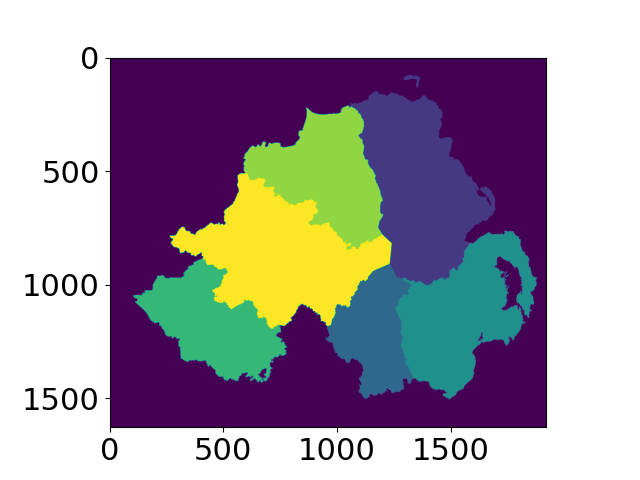

,COUNTY_ID,CountyName,Area_SqKM,OBJECTID,geometry,broadleaf,coniferous,arable,imp_grass,nat_grass,mountain,saltwater,freshwater,coastal,built_up
0,6,TYRONE,3265.796622,1,"POLYGON ((603659.943 6089544.483, 603665.021 6...",72.21,200.69,61.78,2040.78,171.76,545.40,0.00,114.64,0.01,56.49
1,1,ANTRIM,3097.847750,2,"MULTIPOLYGON (((697048.708 6049234.680, 697047...",68.74,124.01,127.66,1736.31,154.42,473.18,1.68,207.10,16.03,187.44
2,2,ARMAGH,1327.228438,3,"POLYGON ((671301.846 6043407.459, 671437.484 6...",35.42,20.46,74.70,960.84,57.10,57.28,0.21,67.26,0.08,53.45
3,4,FERMANAGH,1850.832538,4,"POLYGON ((584348.238 6051633.297, 584365.882 6...",86.13,234.45,4.54,1051.16,85.36,194.65,0.00,171.63,0.00,21.61
4,5,LONDONDERRY,2118.316853,5,"POLYGON ((648345.446 6119413.614, 648346.157 6...",58.76,117.39,166.27,1136.74,175.37,334.91,3.46,29.22,13.73,81.38
5,3,DOWN,2491.238606,6,"MULTIPOLYGON (((691197.830 5992737.953, 691194...",79.33,34.06,469.74,1404.40,113.37,187.95,1.90,13.26,24.46,161.85


In [40]:
fig, ax = plt.subplots(1,1)
ax.imshow(county_mask) # visualize the rasterized output
counties.head(6)

As you can see, this provides us with an __array__ whose values correspond to the `COUNTY_ID` of the county feature at that location (check the `counties` __GeoDataFrame__ again to see which county corresponds to which ID). In the next section, we'll see how we can use arrays like this to investigate our data further.

## 6. Masking and indexing rasters
So far, we've seen how we can index an array (or a list, a tuple, ...) using simple indexing (e.g., `myList[0]`) or _slicing_ (e.g., `myList[2:4]`). `numpy` arrays, however, can [actually be indexed](https://numpy.org/doc/stable/reference/arrays.indexing.html) using other arrays of type `bool` (the elements of the array are boolean (`True`/`False`) values). 

In this section, we'll see how we can use this, along with our rasterized vectors, to select and investigate values from a raster using boolean indexing.

To start, we'll open our dem raster - note that this raster has the same georeferencing information as our landcover raster, so we don't have to load all of that information, just the raster band:

In [41]:
with rio.open('data_files/NI_DEM.tif') as dataset:
    dem = dataset.read(1)

From the previous section, we have an array with values corresponding each of the counties of Northern Ireland. Using `numpy`, we can use this array to select elements of other rasters by creating a _mask_, or a boolean array - that is, an array with values of `True` and `False`. For example, we can create a mask corresponding to County Antrim (`COUNTY_ID=1`) like this:

```python
county_antrim = county_mask == 1
```
Let's see what this mask looks like:

<IPython.core.display.Javascript object>


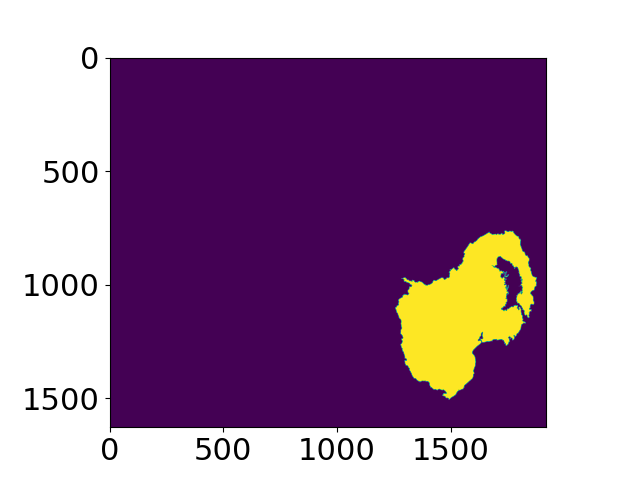

In [42]:
county_antrim = county_mask == 3

fig, ax = plt.subplots(1, 1)
ax.imshow(county_antrim) # visualize the rasterized output

We can also combine expressions using functions like [`np.logical_and()`](https://numpy.org/doc/stable/reference/generated/numpy.logical_and.html) or [`np.logical_or()`](https://numpy.org/doc/stable/reference/generated/numpy.logical_or.html). If we wanted to create a mask corresponding to both County Antrim (`county_mask == 3`) and County Down (`county_mask == 1`), we could do the following:

<IPython.core.display.Javascript object>


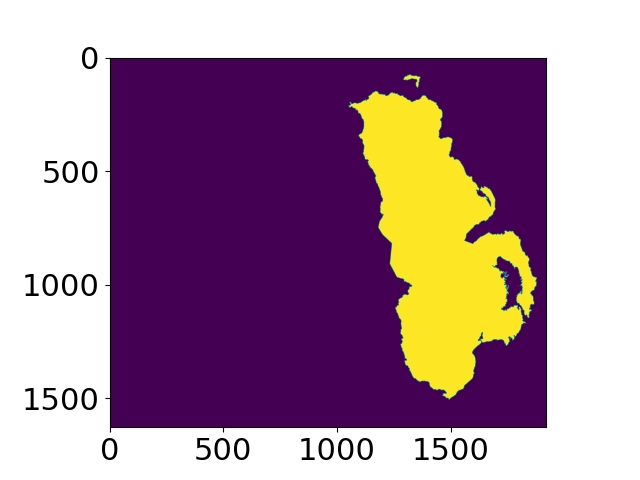

In [43]:
antrim_and_down = np.logical_or(county_mask == 3, county_mask == 1)

fig, ax = plt.subplots(1, 1)
ax.imshow(antrim_and_down)

We could then find the mean elevation of these two counties by indexing, or selecting, pixels from `dem` using our mask:

In [ ]:
ad_elevation = dem[antrim_and_down] # index the array using the antrim_and_down mask
print('Mean elevation: {:.2f} m'.format(ad_elevation.mean()))

Now let's say we wanted to investigate the two types of woodland we have, broadleaf and conifer. One thing we might want to look at is the area-elevation distribution of each type. To do this, we first have to select the pixels from the DEM that correspond to the broadleaf woodlands, and all of the pixels corresponding to conifer woodlands:

In [ ]:
broad_els = dem[landcover == 1] # get all dem values where landcover = 1
conif_els = dem[landcover == 2] # get all dem values where landcover = 2

Now, we have two different arrays, `broad_els` and `conif_els`, each corresponding to the DEM pixel values of each landcover type. We can plot a histogram of these arrays using [`plt.hist()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html), but this will only tell us the number of pixels - to work with areas, remember that we have to convert the pixel counts into areas by multiplying with the pixel area (100 m x 100 m).

First, though, we can use `numpy.histogram()`, along with an array representing our elevation bins, to produce a count of the number of pixels with an elevation that falls within each bin. Let's try elevations ranging from 0 to 600 meters, with a spacing of 5 meters:

In [ ]:
el_bins = np.arange(0, 600, 5) # create an array of values ranging from 0 to 600, spaced by 5.

broad_count, _ = np.histogram(broad_els, el_bins) # bin the broadleaf elevations using the elevation bins
conif_count, _ = np.histogram(conif_els, el_bins) # bin the conifer elevations using the elevation bins

broad_area = broad_count * 100 * 100 # convert the pixel counts to an area by multipling by the pixel size in x, y
conif_area = conif_count * 100 * 100

Finally, we can plot the area-elevation distribution for each land cover type using [`matplotlib.pyplot.bar()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html):

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8)) # create a new figure and axes object

# plot the area-elevation distributions using matplotlib.pyplot.bar(), converting from sq m to sq km:
_ = ax.bar(el_bins[:-1], broad_area / 1e6, align='edge', width=5, alpha=0.8, label='Broadleaf Woodland')
_ = ax.bar(el_bins[:-1], conif_area / 1e6, align='edge', width=5, alpha=0.8, label='Conifer Woodland')

ax.set_xlim(0, 550) # set the x limits of the plot
ax.set_ylim(0, 30) # set the y limits of the plot

ax.set_xlabel('Elevation (m)') # add an x label
ax.set_ylabel('Area (km$^2$)') # add a y label
ax.legend() # add a legend

From this, we can clearly see that Conifer woodlands tend to be found at much higher elevations than Broadleaf woodlands, and at a much larger range of elevations (0-500 m, compared to 0-250 m or so). 

With these samples (`broad_els`, `conif_els`), we can also calculate statistics for each of these samples using `numpy` functions such as `np.mean()`, `np.median()`, `np.std()`, and so on:

In [ ]:
print('Broadleaf mean elevation: {:.2f} m'.format(np.mean(broad_els)))
print('Broadleaf median elevation: {:.2f} m'.format(np.median(broad_els)))
print('Coniferous mean elevation: {:.2f} m'.format(np.mean(conif_els)))
print('Coniferous median elevation: {:.2f} m'.format(np.median(conif_els)))


<span style="color:#009fdf;font-size:1.1em;font-weight:bold">Of the 10 different landcover types shown here, which one has the highest mean elevation? What about the largest spread in elevation values?</span>

In [ ]:
# create a new pandas DataFrame with 6 columns
landcover_els = pd.DataFrame(columns=['name', 'mean', 'median', 'std. dev', 'max', 'min']) 

landcover_els['name'] = short_names # add the short names to the 'name' column

# now, write a loop that will populate the table with descriptive statistics about the elevation
# of each landcover class
#checkout week5 snippetts

## Next steps

That's all for this practical. In lieu of an an additional exercise this week, spend some time working on your project - are there concepts or examples from this practical that you can incorporate into your project?

### Footnotes
[<sup id="fn1">1</sup>](#fn1-back)Rowland, C.S.; Morton, R.D.; Carrasco, L.; McShane, G.; O'Neil, A.W.; Wood, C.M. (2017). Land Cover Map 2015 (25m raster, N. Ireland). NERC Environmental Information Data Centre. [doi:10.5285/47f053a0-e34f-4534-a843-76f0a0998a2f](https://doi.org/10.5285/47f053a0-e34f-4534-a843-76f0a0998a2f)</span>